In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.4)

26.07999999999999

In [4]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

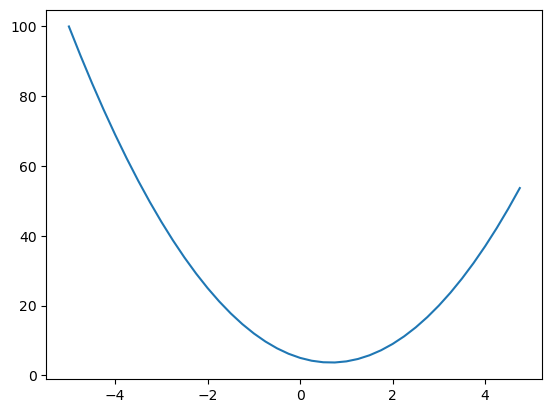

In [5]:
plt.plot(xs,ys)

In [6]:
h=0.0000001
x=2/3
(f(x+h)-f(x))/h

2.9753977059954195e-07

In [7]:
a=2.0
b=-3.0
c=10.0
d=a*b+c
d

4.0

In [8]:
h=0.0001

a=2.0
b=-3.0
c=10.0

d1=a*b+c
a+=h
d2=a*b+c

print('d1 ',d1)
print('d2 ',d2)
print('slope ',((d2-d1)/h))

d1  4.0
d2  3.999699999999999
slope  -3.000000000010772


In [9]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data=data
        self._prev=set(_children)
        self._backward = lambda: None
        self.grad=0.0
        self._op=_op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self + other

    def __sub__(self,other):
        other = other if isinstance(other, (int,float)) else other.data
        return self + (-other)
    
    def __rsub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out = Value(self.data**other,(self, ), _op=f'**{other}')
        
        def _backward():
            self.grad = (other *(self.data**(other -1))) * out.grad
        out._backward = _backward
        
        return out
    
    def __rmul__(self,other):
        return self * other
    
    def __truediv__(self,other):
        return self * other**-1
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n)+1)
        out = Value(t, (self, ), _op='tanh')        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), _op='exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward=_backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        

In [10]:
# a=Value(2.0)
# b=Value(-3.0)
# c=Value(10.0)

# d=a*b+c
# d
a=Value(2.0, label='a')
b=Value(-3.0, label='b')
c=Value(10.0, label='c')
e=a*b; e.label='e'
d=e+c;d.label = 'd'
f=Value(-2.0,label='f')
L=d*f; L.label='L'
L

Value(data=-8.0)

In [11]:
# d._prev
d._op

'+'

In [12]:
from graphviz import Digraph

def trace(root):
    nodes,edges=set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid,label="{ %s | data %.4f | grad %.4f }" % (n.label,n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op , label = n._op)
            dot.edge(uid + n._op, uid )

    for n1, n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)

    return dot

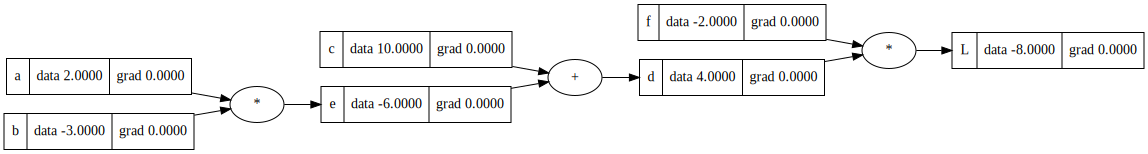

In [13]:
draw_dot(L)

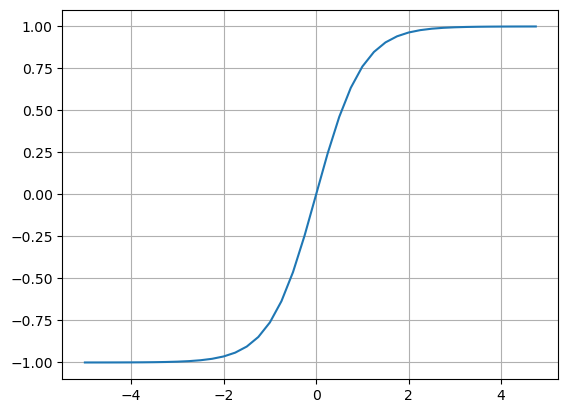

In [15]:
plt.plot(np.arange(-5,5,0.25),np.tanh(np.arange(-5,5,0.25)))
plt.grid()

In [16]:
#inputs X1, X2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights W1, W2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'

n = x1w1x2w2+b; n.label = 'n'

o = n.tanh(); o.label = 'O'

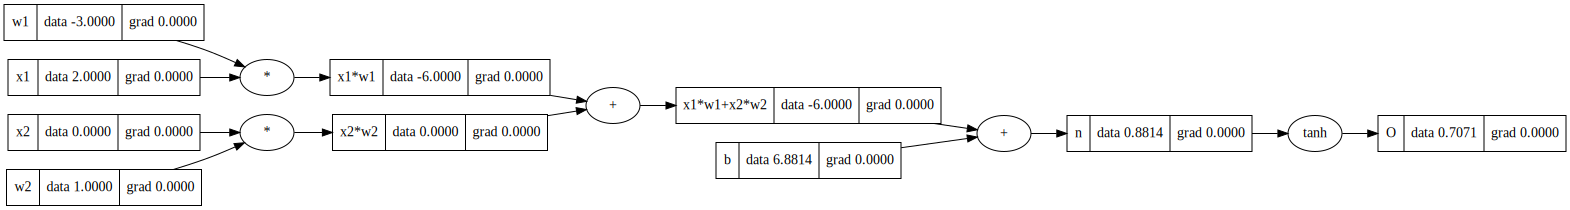

In [17]:
draw_dot(o)

In [18]:
o.grad=1.0

#o = tanh(n); do/dn = 1-(tanh(n))^2 => 1-o^2
n.grad = 1 - o.data*o.data

#n = b + x1w1 + x2w2
b.grad = n.grad
x1w1x2w2.grad = n.grad

#x1w1x2w2 = x1w1 + x2w2
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad

#x1w1 = x1*w1
x1.grad = w1.data*x1w1.grad
w1.grad = x1.data*x1w1.grad

#x2w2 = x2*w2
x2.grad = w2.data*x2w2.grad
w2.grad = x2.data*x2w2.grad



In [19]:
o.grad = 1.0
o._backward()

In [20]:
n._backward()

In [21]:
x1w1x2w2._backward()

In [22]:
x1w1._backward()
x2w2._backward()

In [23]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [24]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [25]:
o.backward()

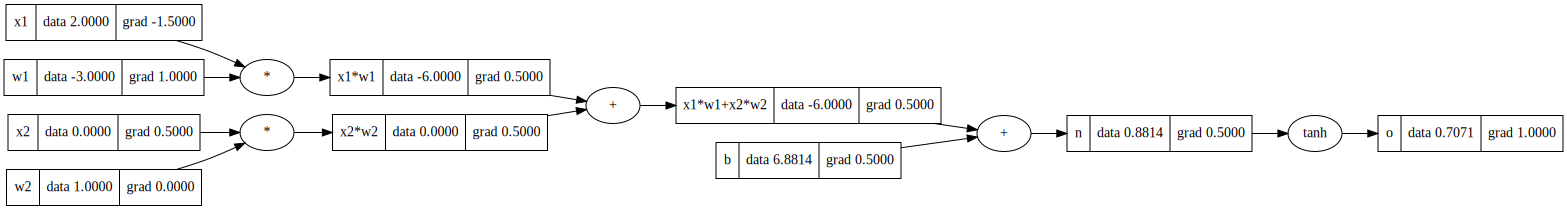

In [26]:
#inputs X1, X2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights W1, W2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'

n = x1w1x2w2+b; n.label = 'n'

o = n.tanh(); o.label = 'o'

o.backward()
draw_dot(o)

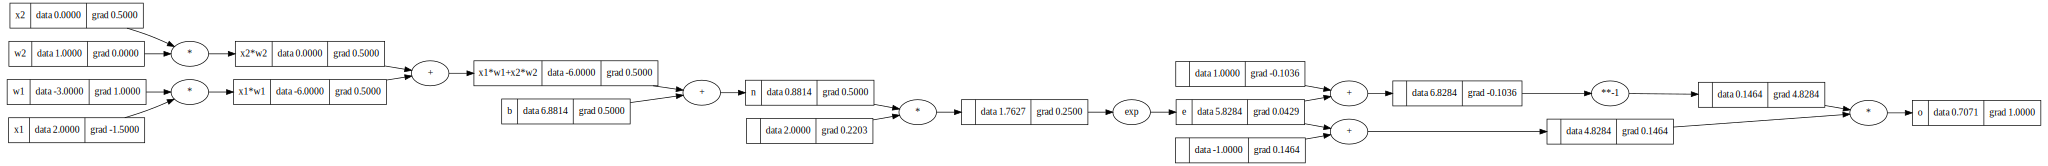

In [27]:
#inputs X1, X2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')

#weights W1, W2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')

#bias
b = Value(6.8813735870195432, label = 'b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1+x2*w2'

n = x1w1x2w2+b; n.label = 'n'
e = (2*n).exp(); e.label = 'e'
o = (e - 1)/(e + 1); o.label = 'o'

o.backward()
draw_dot(o)

In [149]:
import random
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

In [150]:
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
#         params = []
#         for neuron in self.neurons:
#             ps = neuron.parameters()
#             params.extend(ps)
#         return params
        return [p for neuron in self.neurons for p in neuron.parameters()]

In [151]:
x = [2.0, 3.0]
l = Layer(2,3)
l(x)

[Value(data=-0.9355851734303087),
 Value(data=-0.9053957819019206),
 Value(data=0.9921308698276019)]

In [152]:
class MLP:
    
    def __init__(self, nin, nout):
        size = [nin] + nout
        self.layers = [Layer(size[i],size[i+1]) for i in range(len(nout))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [153]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.21751429723645718)

In [154]:
n.parameters()

[Value(data=-0.9093705160987122),
 Value(data=-0.4495957868307756),
 Value(data=0.8371660208320404),
 Value(data=-0.8765715870731796),
 Value(data=-0.475009052991741),
 Value(data=-0.7223184419138944),
 Value(data=0.7786841095237331),
 Value(data=0.5381971685747795),
 Value(data=0.08781230399613271),
 Value(data=-0.1812274170020225),
 Value(data=-0.4091102258297372),
 Value(data=0.8170058511443423),
 Value(data=0.26890888335518004),
 Value(data=-0.4953924032314596),
 Value(data=0.2709331658728378),
 Value(data=0.23366546041972835),
 Value(data=0.9202816040612463),
 Value(data=0.9525629772310087),
 Value(data=0.8356443423961659),
 Value(data=0.38798198775807147),
 Value(data=-0.4939551047056743),
 Value(data=0.411192231520197),
 Value(data=0.3459194816359108),
 Value(data=-0.31038057711035383),
 Value(data=0.4970226305588812),
 Value(data=-0.289550354468578),
 Value(data=-0.9073229146176882),
 Value(data=-0.9994752616387459),
 Value(data=-0.7657040548828427),
 Value(data=-0.589063565412

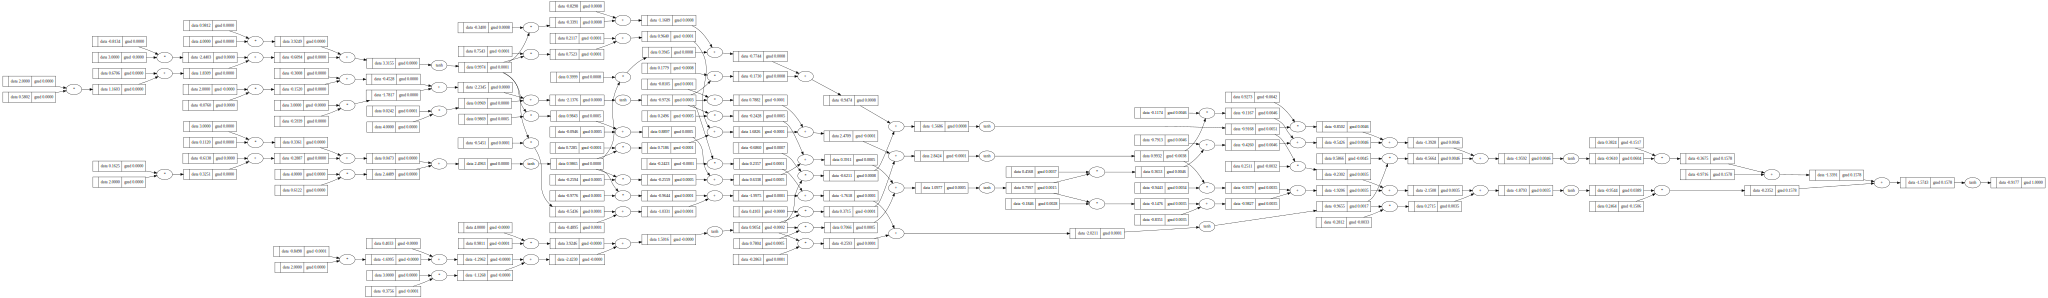

In [138]:
x = [2.0,3.0,4.0]
mlp = MLP(3,[4,4,2,1])
o=mlp(x)
o.backward()
draw_dot(o)

In [191]:
def loss(yact, ypred):
    los=[]
    for ya,yp in zip(yact,ypred):
        los+=[(ya-yp)**2]
    return sum(los)
loss([2.0,3.0,-1.0],[2.0,4.0,1.0])

5.0

In [210]:
n = MLP(3, [4,4,1])

xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.44277170383294007),
 Value(data=0.8595718205865343),
 Value(data=0.2586680866102487),
 Value(data=0.7287983263272336)]

In [179]:
loss = loss(ys,ypred)

In [180]:
loss.backward()

In [181]:
n.layers[0].neurons[0].w[0].grad

0.27781500522008085

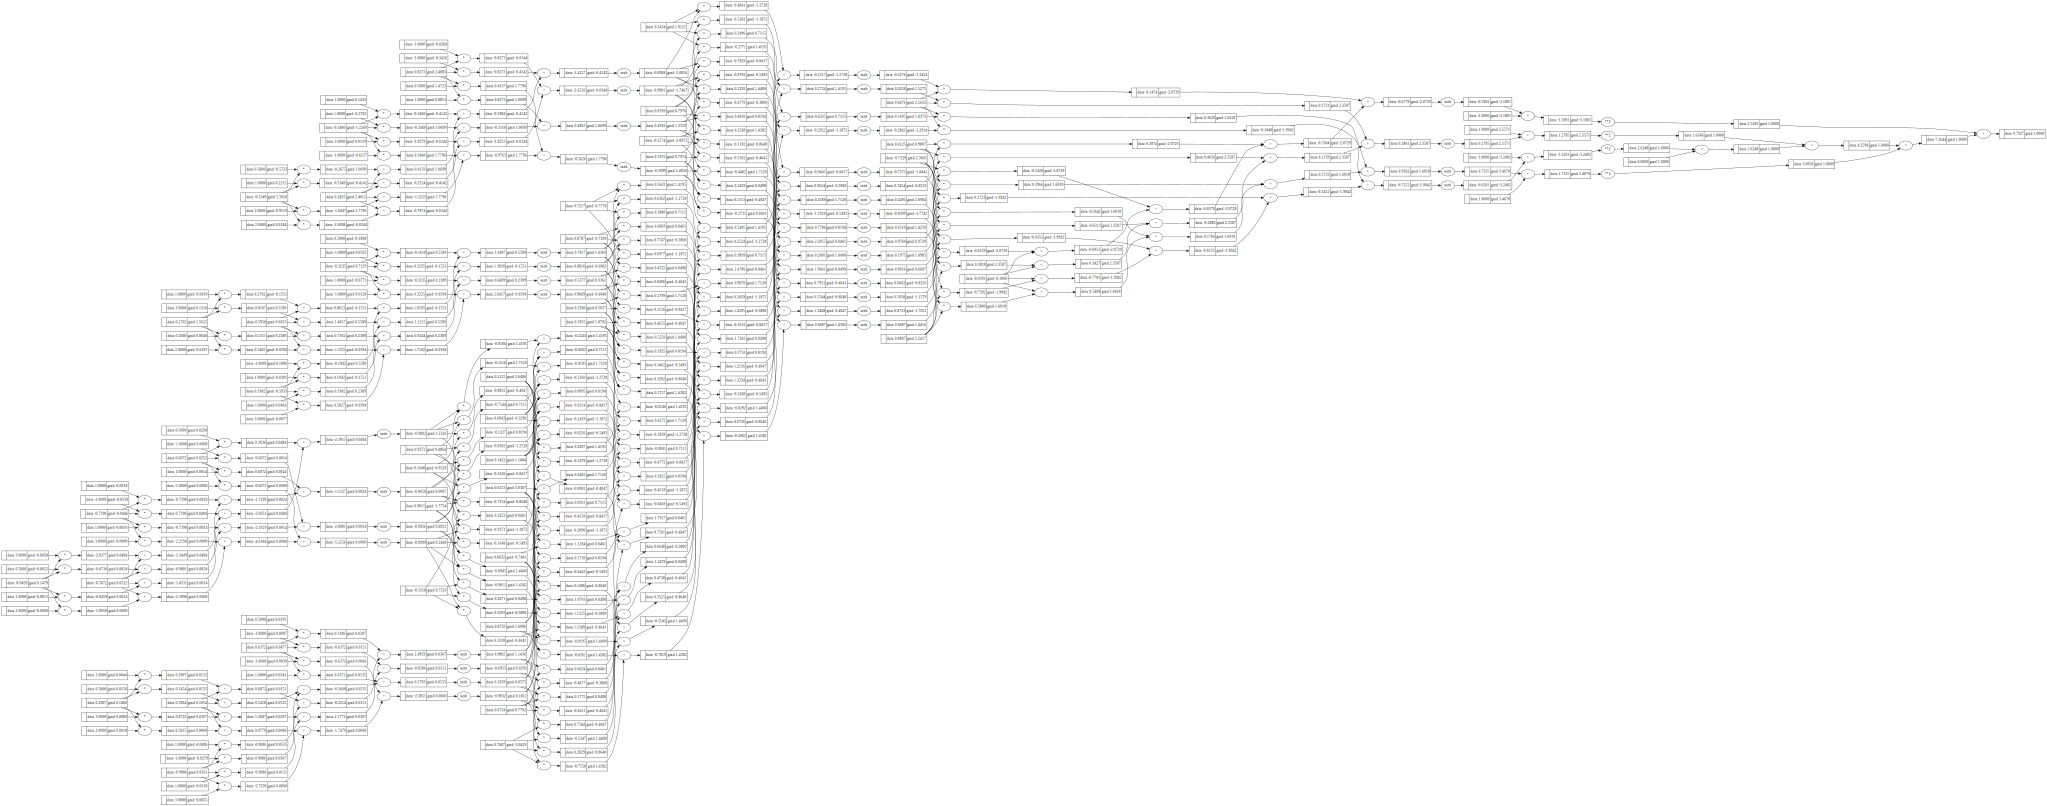

In [144]:
draw_dot(loss)

In [182]:
print(loss)

Value(data=7.035725822931597)


In [183]:
n.parameters()

[Value(data=0.7135944556878613),
 Value(data=-0.04367562349366816),
 Value(data=-0.7205946173738933),
 Value(data=-0.6704103837960691),
 Value(data=0.9654899290329109),
 Value(data=-0.937668700935814),
 Value(data=-0.09098794374672092),
 Value(data=0.7174169437840527),
 Value(data=0.8838181831662666),
 Value(data=0.5720495299635806),
 Value(data=-0.5644358154639855),
 Value(data=-0.13750754177327673),
 Value(data=-0.7390640354428961),
 Value(data=-0.09480392042434649),
 Value(data=-0.472368203674145),
 Value(data=0.4832723918384467),
 Value(data=-0.06997125378829394),
 Value(data=-0.6903872421481863),
 Value(data=0.8746508079843187),
 Value(data=0.7604582647790259),
 Value(data=-0.8572711743008261),
 Value(data=0.6561923176376219),
 Value(data=0.36033902667103),
 Value(data=-0.2963552049327016),
 Value(data=0.42479840806536817),
 Value(data=-0.8223223552617371),
 Value(data=-0.3416542555488342),
 Value(data=0.43128414599644094),
 Value(data=-0.4474531722091546),
 Value(data=0.299262163

In [190]:
for p in n.parameters():
    p.data += -0.01*p.grad

In [192]:
ypred = [n(x) for x in xs]
loss(ys, ypred)

Value(data=6.783494344767601)

In [220]:
stepsize=0.05
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in n.parameters():
        p.data += -stepsize*p.grad
    
    print(k, loss.data)

0 0.004849864157538818
1 0.004817465749459682
2 0.004785475678245336
3 0.004753886440031943
4 0.004722690711386043
5 0.004691881343959274
6 0.004661451359330687
7 0.004631393944029527
8 0.004601702444730597
9 0.004572370363615729
10 0.0045433913538944475
11 0.004514759215477869
12 0.0044864678907993675
13 0.004458511460776558
14 0.0044308841409088995
15 0.004403580277505904
16 0.004376594344040448
17 0.004349920937622976
18 0.004323554775591529
19 0.0042974906922132825


In [221]:
ypred

[Value(data=0.9782858299374417),
 Value(data=-0.9629114318945776),
 Value(data=-0.9659852364853793),
 Value(data=0.9640358582802057)]